In [2]:
import re
import os

import numpy as np
import tifffile
from ome_types import from_tiff, from_xml, to_xml, model
from ome_types.model.simple_types import UnitsLength
import matplotlib.pyplot as plt

from mip.utils import listfiles

In [3]:
fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_and_HT427P1_S1H1A3/level_2/stitched/stitched.qptiff'
output_fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_and_HT427P1_S1H1A3/level_2/stitched/HT206B1-S1H2L4_and_HT427P1_S1H1A3.ome.tiff'

In [3]:
img = tifffile.imread(fp)

In [4]:
img.shape

(21, 36720, 18240)

In [5]:
img.dtype

dtype('uint8')

In [6]:
tf = tifffile.TiffFile(fp)

In [68]:
s = tf.series[0]
s.get_shape()

(21, 36720, 18240)

In [42]:
for s in tf.series:
    print(s.name)

Baseline
Thumbnail
Macro
Label


Thumbnail


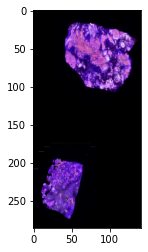

Macro


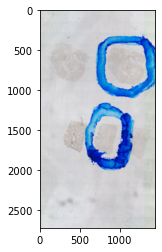

Label


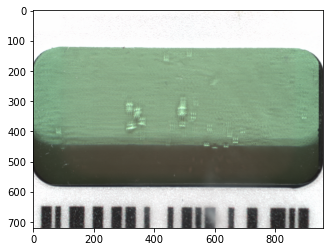

In [67]:
for s in tf.series:
    if s.name != 'Baseline':
        print(s.name)
        plt.imshow(s.asarray())
        plt.show()

In [69]:
p = next(iter(tf.series[0].pages))

In [77]:
36720 / 1440

25.5

In [70]:
tifffile.xml2dict(p.description)

{'PerkinElmer-QPI-ImageDescription': {'DescriptionVersion': 4,
  'AcquisitionSoftware': 'Fusion 1.0.5',
  'ImageType': 'FullResolution',
  'Identifier': '59ba0125-58aa-4017-8dfe-a0332f21aac5',
  'SlideID': 'HT206B1_Lrg_HT274P1_Sml',
  'Barcode': None,
  'ComputerName': 'AKYAJX89WM3',
  'IsUnmixedComponent': False,
  'ExposureTime': 1000,
  'SignalUnits': 64,
  'Name': 'DAPI',
  'Color': '0,0,255',
  'Responsivity': {'Filter': {'Name': 'DAPI',
    'Response': 357.52335217527,
    'Date': '2022-09-27T21:06:18.9805815Z',
    'FilterID': 'DAPI_Semrock:FF01-453/605/832 / Semrock:FF01-391/545/735-25'}},
  'Objective': '20xLWD',
  'Biomarker': 'DAPI',
  'AutofluorescenceSubtracted': True,
  'ScaleFactor': 2.0001,
  'SampleDescription': 'Larger section is BRCA selected by Alla, smaller is PDAC selected by Austin',
  'StudyName': 'Cancer Common Panel',
  'OperatorName': 'Akoya Biosciences',
  'ExcitationFilter': {'Name': 'DAPI / ATTO550 / AF750',
   'Manufacturer': 'Semrock',
   'PartNo': 'FF01

In [71]:
img = p.asarray()
img.shape, img.dtype

((36720, 18240), dtype('uint8'))

In [72]:
# for p in tf.series[0].pages:
#     print(tifffile.xml2dict(p.description))
#     print('\n\n\n')

In [76]:
s.get_shape()

(21, 36720, 18240)

In [74]:
for i, p in enumerate(tf.series[0].pages):
    d = tifffile.xml2dict(p.description)['PerkinElmer-QPI-ImageDescription']
    
    print(i, 'biomarker', d.get('Biomarker', ''))
#     print(i, 'name', d.get('Name', ''))

0 biomarker DAPI
1 biomarker CK19 (D)
2 biomarker CD31
3 biomarker CD4
4 biomarker CD8
5 biomarker Pan-Cytokeratin
6 biomarker Histone H3 Phospho (Ser28)
7 biomarker Podoplanin
8 biomarker CK17 (D)
9 biomarker CD3e
10 biomarker Keratin 14
11 biomarker SMA (D)
12 biomarker CD68
13 biomarker CD20 (D)
14 biomarker Vimentin (D)
15 biomarker CD11c
16 biomarker Ki67
17 biomarker HLA-DR
18 biomarker CD163
19 biomarker FoxP3
20 biomarker PD-1


In [13]:
36720 / (18.73 * 1000)

1.9604911906033102

In [17]:
18.73 * 1000

18730.0

In [18]:
36720 / 1.9604911906033102

18730.0

In [8]:
PHENOCYCLER_PIXELS_PER_MICRON = 1.9604911906033102
def generate_ome_from_qptiff(qptiff_fp, output_fp):
    """
    Generate an HTAN compatible ome tiff from qptiff output by codex phenocycler
    """
    tf = tifffile.TiffFile(qptiff_fp)

    s = tf.series[0] # full res tiffs are in the first series

    x, y = None, None
    with tifffile.TiffWriter(output_fp, ome=True, bigtiff=True) as out_tif:
        biomarkers = []
        for i, p in enumerate(s.pages):
            img = p.asarray()
            x, y = img.shape[1], img.shape[0]
            d = tifffile.xml2dict(p.description)['PerkinElmer-QPI-ImageDescription']
            biomarkers.append(d['Biomarker'])
            print(i, d['Biomarker'])
            out_tif.write(img) # phenocycler outputs are uint8
        o = model.OME()
        o.images.append(
            model.Image(
                id='Image:0',
                pixels=model.Pixels(dimension_order='XYCZT',
                size_c=s.get_shape()[0],
                size_t=1,
                size_x=x,
                size_y=y,
                size_z=1,
                type='float',
                big_endian=False,
                channels=[model.Channel(id=f'Channel:{i}', name=c) for i, c in enumerate(biomarkers)],
                physical_size_x=x / PHENOCYCLER_PIXELS_PER_MICRON,
                physical_size_y=y / PHENOCYCLER_PIXELS_PER_MICRON,)
            )
        )

        im = o.images[0]
        im.pixels.physical_size_x_unit = 'µm'
        im.pixels.physical_size_y_unit = 'µm'
        for i in range(len(im.pixels.channels)):
            im.pixels.planes.append(model.Plane(the_c=i, the_t=0, the_z=0))
        im.pixels.tiff_data_blocks.append(model.TiffData(plane_count=len(im.pixels.channels)))
        xml_str = to_xml(o)
        out_tif.overwrite_description(xml_str.encode())

In [9]:
generate_ome_from_qptiff(fp, output_fp)

(36720, 18240) uint8
0 DAPI
(36720, 18240) uint8
1 CK19 (D)
(36720, 18240) uint8
2 CD31
(36720, 18240) uint8
3 CD4
(36720, 18240) uint8
4 CD8
(36720, 18240) uint8
5 Pan-Cytokeratin
(36720, 18240) uint8
6 Histone H3 Phospho (Ser28)
(36720, 18240) uint8
7 Podoplanin
(36720, 18240) uint8
8 CK17 (D)
(36720, 18240) uint8
9 CD3e
(36720, 18240) uint8
10 Keratin 14
(36720, 18240) uint8
11 SMA (D)
(36720, 18240) uint8
12 CD68
(36720, 18240) uint8
13 CD20 (D)
(36720, 18240) uint8
14 Vimentin (D)
(36720, 18240) uint8
15 CD11c
(36720, 18240) uint8
16 Ki67
(36720, 18240) uint8
17 HLA-DR
(36720, 18240) uint8
18 CD163
(36720, 18240) uint8
19 FoxP3
(36720, 18240) uint8
20 PD-1
